# Обучение нейронной сети

Это последняя и самая важная практика в этом блоке. В ней вы соберете воедино все, что мы с вами изучили и примените для создания сети, которая классифицирует рукописные цифры.

Задание будет состоять из следующих этапов:
1.  Реализация слоя ReLU
2.  Реализация полносвязного слоя
3.  Написание обучающего цикла
4.  Загрузка данных и обучение сети


**Задание 1**
Написание слоя ReLU. В этом задании вы реализуете слой нейронной сети, который вычисляет поэлементно функцию ReLU:

$$
ReLU(x) = max(0, x)
$$

и выгядит следующим образом:

![alt text](https://miro.medium.com/max/536/1*oePAhrm74RNnNEolprmTaQ.png)

Нетрудно заметить, что производная при $x > 0$ равна $1$, а при $x < 0$ равна $0$. Это вам пригодится при реализации backward pass

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from typing import List
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output


In [24]:
class Layer:
    """
    Базовый класс слоя нашей нейронной сети. 
    Все слои должны наследоваться от него и реализовывать два метода: forward и backward
    """
    def forward(self, x):
        pass
    def backward(self, dL_dz, learning_rate=0):
        pass

class ReLU(Layer):
    """
    Слой ReLU
    """
    def forward(self, x):
        """
        Метод, который вычисляет ReLU(x)

        Размер выхода должен совпадать со входом

        """

        self._saved_input = x # нам необходимо сохранить вход
        output = None

        # < YOUR CODE STARTS HERE >
        # переменная output должна содержать выход ReLU
        
        output = np.maximum(x, np.zeros(x.shape))
        
        # < YOUR CODE ENDS HERE >
        assert output.shape == x.shape
        return output

    def backward(self, dL_dz, learning_rate=0.):
        """
        dL_dz -- производная финальной функции по выходу этого слоя.
                 Размерость должна в точности соответствовать размерности
                 x, который прошел в forward pass.
        learning_rate -- не используется, т.к. ReLU не содержит параметров.

        Метод должен посчитать производную dL_dx.
        Благодаря chain rule, мы знаем, что dL_dx = dL_dz * dz_dx
        и при этом dL_dz нам известна.

        Для слоя relu, dz_dx(x) = 1, при x > 0, и dz_dz = 0 при x < 0
        
        * сохраненный инпут находится в self._saved_input
        """
        dz_dx = None
        
        # < YOUR CODE STARTS HERE >
        # переменная dz_dx должна содержать производную выхода ReLU по ее входу
        
        dz_dx = np.greater(self._saved_input, np.zeros(self._saved_input.shape))
        
        # < YOUR CODE ENDS HERE >
        assert dz_dx.shape == self._saved_input.shape, f"Shapes must be the same. Got {dz_dx.shape, self._saved_input.shape}"
        output = dz_dx * dL_dz
        return output


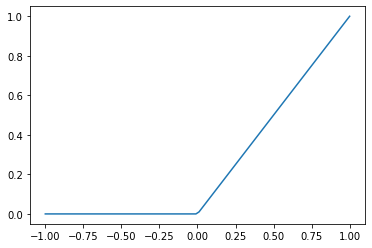

In [25]:
relu = ReLU()

# убедитесь, что график соответствует представленному вверху
plt.plot(np.linspace(-1, 1, 100), relu.forward(np.linspace(-1, 1, 100)))

In [26]:
f = lambda x: ReLU().forward(x)

x = np.linspace(-1, 1, 10*32).reshape([10, 32])
l = ReLU()
l.forward(x)
grads = l.backward(np.ones([10, 32]))
numeric_grads = derivative(f, x, dx=1e-6)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
     "gradient returned by your layer does not match the numerically computed gradient"
print("Test passed")

Test passed


**Задание 2** Реализация полносвязного слоя. 

Закончите реализацию метода forward для полносвязного слоя

In [28]:
class FCLayer(Layer):
    """
    Полносвязный (fully connected/dense) слой
    """
    def __init__(self, in_dim, out_dim):
        """
        in_dim, out_dim -- количество входных и выходных нейронов соответственно
        """
        self.in_dim = in_dim
        self.out_dim = out_dim
        # инициализируем матрицу весов (in_dim,out_dim) нормальным распределением
        self.weights = np.random.randn(in_dim,out_dim)*0.001

        # инициализируем смещение нулями
        self.bias = np.zeros(self.out_dim)
        self._saved_input = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Вычисление выхода полносвязного слоя.

        x -- вход слоя, размерности (N, in_dim), где N -- количество объектов 
             в батче

        return: matmul(x, weights) + bias
        """
        assert np.ndim(x) == 2
        assert x.shape[1] == self.in_dim
        self._saved_input = x

        # < YOUR CODE STARTS HERE >
        # переменная output должна содержать выход полносвязного слоя
        
        output = np.dot(x, self.weights) + self.bias
        
        # < YOUR CODE ENDS HERE >

        assert output.shape == (x.shape[0], self.out_dim), (output.shape, (x.shape[0], self.out_dim))
        return output
    
    def backward(self, dL_dz, learning_rate=0.):
        """
        dL_dz -- производная финальной функции по выходу этого слоя.
                 Размерость (N, self.out_dim).
        learning_rate -- если отличен от нуля, то с вызовом этой функции, параметры
                         слоя (weights, bias) будут обновлены

        Метод должен посчитать производную dL_dx.
        
        """
        assert np.ndim(dL_dz) == 2
        assert dL_dz.shape[1] == self.out_dim
        
        # очень рекомендуем понять почему это так,
        # хорошее объяснение здесь: http://cs231n.stanford.edu/handouts/linear-backprop.pdf
        self.dL_dw = np.dot(self._saved_input.T, dL_dz)
        self.dL_dx = np.dot(dL_dz, self.weights.T)
        self.dL_db = dL_dz.sum(0) 
        
        assert self.dL_db.shape == self.bias.shape
        assert self.dL_dw.shape == self.weights.shape
        assert self.dL_dx.shape == self._saved_input.shape

        if learning_rate != 0:
            # знакомый вам шаг градиентного спуска!
            self.weights -= learning_rate * self.dL_dw
            self.bias -= learning_rate * self.dL_db
        
        return self.dL_dx



Теперь перейдем к вычислению лосса. Т.к. перед нами стоит задача мультиклассовой классификации, то мы будем использовать multiclass_cross_entropy_loss, который мы рассмотрели на лекции.
Такой лосс на одном объекте $i$, который принадлежит к классу $k$ будет равен: 
$$
loss_i = -log(p_i^k),
$$
где $p_i^k$ -- предсказанная вероятность того, что $i$ый объект принадлежит к классу $k$.

Для того, чтобы получить вероятности, мы использовали Softmax, примененный в логитам выходного слоя. Т.е. 
$$
p_i^k = \frac{exp(logit_k)}{\sum_{j=0}^{m} exp(logit_j)}
$$

А значит лосс можно переписать так:
$$
loss_i = -log(p_i^k) = -logit_k + log(\sum_{j=0}^{m} exp(logit_j))
$$

Как мы помним, сеть изначально предсказывает логиты, и затем мы превращаем их в вероятности. Но т.к. мы знаем, что нам предстоит считать лосс, то мы можем не тратить "силы" на вычисление вероятностей и посчитать лосс основываясь на логитах. Такая запись проще и вычислительно более стабильная. 

Ниже мы приводим готовую реализацию лосса и его градиента.

In [29]:
def multiclass_crossentropy_with_logits(logits, y_true):
    """
    logits -- выход нейронной сети без активации. Размерность: (N, k),
              где N -- количество объектов, k -- количество классов
    y_true -- реальные классы для N объектов

    Класс возвращает вектор из лоссов на каждом объекте
    
    """

    logits_for_answers = logits[np.arange(len(logits)), y_true]
    
    cross_entropy = -logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return cross_entropy

def grad_multiclass_crossentropy_with_logits(logits, y_true):
    """
     logits -- выход нейронной сети без активации. Размерность: (N, k),
              где N -- количество объектов, k -- количество классов
    y_true -- реальные классы для N объектов

    Класс возвращает матрицу производных.
    
    """
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), y_true] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]    

**Задание 3** Реализация класса  Network.

В этом задании вам предлагается реализовать методы forward(), predict(), train_step(). Это последний шаг перед тем как наша сеть будет готова!

In [30]:
class Network:
    """
    Нейронная сеть

    """
    def __init__(self, layers: List[Layer]):
        """
        Для инициализации нейронной сети, нам нужен список слоев, которые должны
        быть последовательно применены друг к другу. 

        """
        self.layers = layers
    
    def forward(self, x: np.ndarray):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)
        
        Получив x на вход, сеть должна по-очереди применить к нему все слои.
        Т.е. выход каждого слоя является входом следующего.

        x -> layer_0 -> layer_1 ... -> last_layer

        """
        output = x
        # < YOUR CODE STARTS HERE >
        # Реализуйте последовательное применение forward методов каждого из 
        # слоев (self.layers)
        
        for layer in self.layers:
          output = layer.forward(output)



        # < YOUR CODE ENDS HERE >
        
        return output

    def predict(self, x):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)
        
        Функция должна вернуть вектор размера (N) с номером предсказанного класса
        для каждого объекта. 

        """
        logits = self.forward(x) # считаем логиты сделав полный форвард пасс сети
        # напомним, что размер логитов (N, k), где k -- количество классов
        
        classes = None
        # < YOUR CODE STARTS HERE >
        # реализуйте получение классов из логитов. вам может пригодится 
        # метод argmax

        classes = np.argmax(np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True), axis=-1)

        # < YOUR CODE ENDS HERE >

        assert classes.shape == (x.shape[0],)
        return classes
    
    def train_step(self, x, y, learning_rate):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)
        y -- реальные классы объектов (N,)
        """
        logits = self.forward(x)
        loss = multiclass_crossentropy_with_logits(logits, y)
        loss_grad = grad_multiclass_crossentropy_with_logits(logits, y)
        
        # < YOUR CODE STARTS HERE >
        # Выше мы получили loss_grad. Теперь его нужно "пробросить" через всю сеть
        # вызывая backward каждого слоя в обратном порядке.
        # Не забудьте передать в backward -- learning rate.
        # loss_grad -> last_layer.backward(loss_grad, lr) -> ... --> layer_0.backward(loss_grad_from_layer_1, lr)
        for i in range(len(self.layers)-1, -1, -1):
            layer = self.layers[i]
            loss_grad = layer.backward(loss_grad, learning_rate)

        
        # < YOUR CODE ENDS HERE >

        return np.mean(loss)
    
    def fit(self, x_train, y_train, x_test, y_test, learning_rate, num_epochs, 
            batch_size):
        """
        Цикл обучения уже реализован. Основная его задача -- итерироваться по 
        минибатчам и вызывать на каждом из них train_step, который вы уже реализовали.

        В остальном -- это логирование лосса, точности и отрисовка графика.

        """
        train_log = []
        test_log = []
        loss_log = []

        for epoch in range(num_epochs):
            loss_iters = []
            for x_batch,y_batch in iterate_minibatches(x_train, y_train, 
                                                       batchsize=batch_size, shuffle=True):
                loss_iters.append(self.train_step(x_batch, y_batch, learning_rate=learning_rate))

            loss_log.append(np.mean(loss_iters)) # для визуализации усредняем лосс за каждую итерацию
            train_accuracy = accuracy_score(y_train, self.predict(x_train))
            test_accuracy = accuracy_score(y_test, self.predict(x_test))
            train_log.append(train_accuracy)
            test_log.append(test_accuracy)

            clear_output()
            print("Epoch", epoch)
            print("Train accuracy:",train_log[-1])
            print("Test accuracy:",test_log[-1])
            plt.figure(figsize=(10, 5))
            ax1 = plt.subplot(1,2,1)    
            plt.plot(train_log,label='train accuracy')
            plt.plot(test_log,label='test accuracy')
            ax2 = plt.subplot(1,2,2)
            plt.plot(loss_log,label='loss')
            ax1.legend(loc='best')
            ax2.legend(loc='best')
            plt.grid()
            plt.tight_layout()
            plt.show()

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            batch_indexes = indices[start_idx:start_idx + batchsize]
        else:
            batch_indexes = slice(start_idx, start_idx + batchsize)
            
        yield inputs[batch_indexes], targets[batch_indexes]

## Обучение
На этом этапе наша сеть полностью описаны и готова к бою. Нам нужны теперь только данные.

Мы поставим перед собой задачу классифицировать изображения рукописных цифр. Они представляют собой картинки размера (28, 28). Для использования нашей сети мы превратим их в строчки длины $28*28 = 784$.

Давайте посмотрим как они выглядят:

In [31]:
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

(60000, 784) (10000, 784)


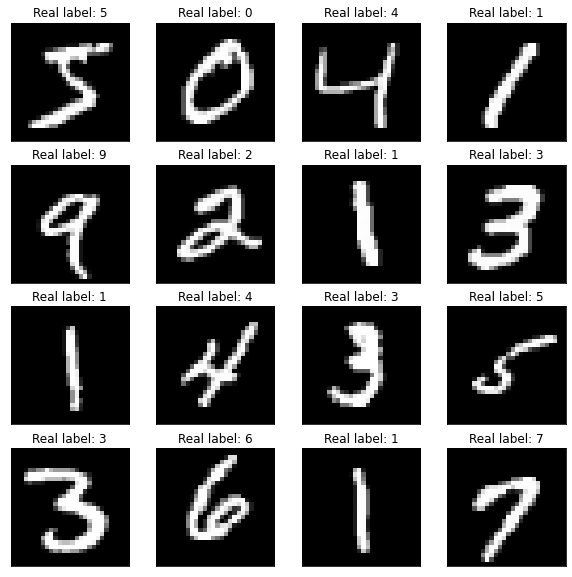

In [32]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

show_mnist(train_images, train_labels)

# преобразуем изображения к нужному виду
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255.
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255.
print(train_images.shape, test_images.shape)

Epoch 9
Train accuracy: 0.9896333333333334
Test accuracy: 0.9748


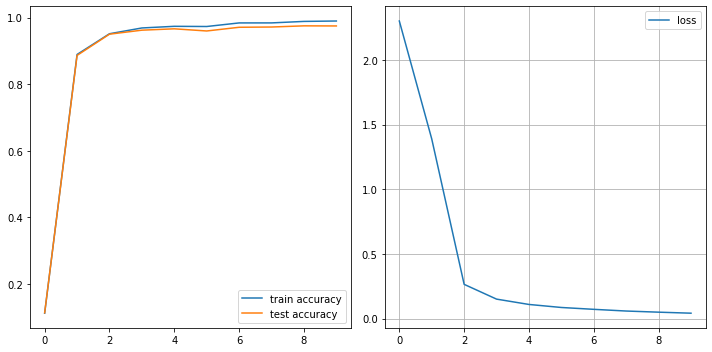

In [33]:
# Наша сеть будет состоять из одного скрытого слоя
layers = []
layers.append(FCLayer(train_images.shape[1], 100)) # входной слой
layers.append(ReLU()) # активация
layers.append(FCLayer(100, 200)) # скрытый слой
layers.append(ReLU()) # активация
layers.append(FCLayer(200, 10)) # выходной слой -- 10 классов (10 цифр). Обратите внимание, мы не используем активацию!
                                # т.к. лосс рассчитывает на логиты, а не вероятности

# инициализируем наш класс указанными слоями
net = Network(layers=layers)
# если все реализовано правильно -- точность на отложенной части выборки достигнет 97%
net.fit(x_train=train_images, y_train=train_labels, 
        x_test=test_images, y_test=test_labels,
        batch_size=32, num_epochs=10, learning_rate=0.1)

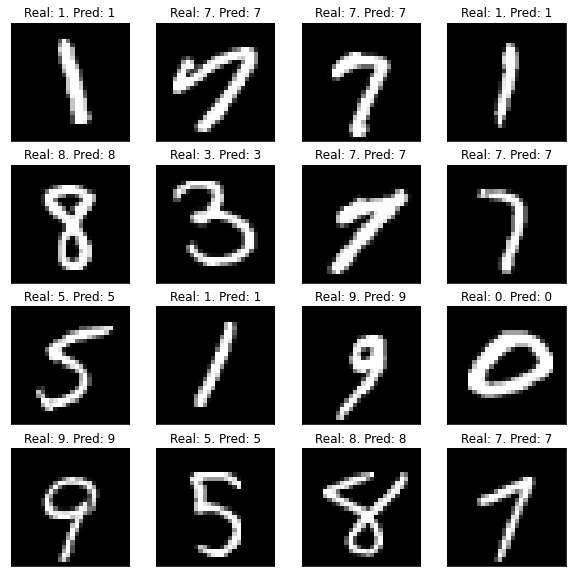

In [34]:
predicted_labels = net.predict(test_images)
idxs = np.random.choice(np.arange(len(test_images)), 16, replace=False)
show_mnist(test_images[idxs].reshape((-1, 28, 28)), test_labels[idxs], predicted_labels[idxs])